In [1]:
import os

In [2]:
from google.colab import drive
drive._mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# importing all the required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import IPython.display as ipd

In [6]:
from torchvision import transforms
from tqdm import tqdm

In [7]:
import glob
from PIL import Image

In [8]:
visual_images_path = '/content/visual_frames_final'
all_image_files = sorted(glob.glob('/content/visual_frames_final/*/*.jpg'))

In [9]:
all_audio_files = sorted(glob.glob('/content/Audio*/*/*.wav'))

In [10]:
len(all_audio_files), len(all_image_files)

(2496, 62042)

In [11]:
label_to_emotion = {'01':'neutral', 
                    '02': 'calm', 
                    '03': 'happy',
                    '04': 'sad',
                    '05': 'angry',
                    '06': 'fearful',
                    '07': 'disgust',
                    '08': 'surprised'}

In [62]:

all_emotions = [x[1] for x in label_to_emotion.items()]

In [12]:
FILES = {'filepath':[], 
         'label':[], 
         'emotion': [],
         'actor':[], 
         'intensity': [], 
         'duration': [],
         'image_paths': []}
want_duration = False
for wav_file in tqdm(all_audio_files):
  filename = wav_file.replace('.wav', '')
  label = os.path.basename(filename).split('-')[2]
  intensity = os.path.basename(filename).split('-')[3]
  actor = os.path.basename(filename).split('-')[-1]
  
  # filling the dictionary
  FILES['filepath'].append(wav_file)
  FILES['label'].append(label)
  FILES['emotion'].append(label_to_emotion[label])
  FILES['actor'].append(actor)
  FILES['intensity'].append(intensity)
  if want_duration:
    FILES['duration'].append(librosa.get_duration(filename=wav_file))
  else:
    FILES['duration'].append(0.0)
  
  # for video face extraction
  video_file = wav_file
  vid_tag = "=".join(video_file.split('/')[-2:]).replace('.wav', '')
  label = os.path.basename(video_file).split('-')[2]
  label_dir = os.path.join(visual_images_path, label)

  savepath = os.path.join(label_dir, f'{vid_tag}=*.jpg').replace('=03-', '=01-')
  imgpaths = sorted(glob.glob(savepath)) or 'NAH'

  FILES['image_paths'].append(imgpaths)


100%|██████████| 2496/2496 [00:25<00:00, 96.71it/s] 


In [13]:
df = pd.DataFrame(FILES)
df

,filepath,label,emotion,actor,intensity,duration,image_paths
0,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
1,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
2,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
3,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
4,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,02,calm,01,01,0.0,[/content/visual_frames_final/02/Actor_01=01-0...
...,...,...,...,...,...,...,...
2491,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,01,0.0,[/content/visual_frames_final/08/Actor_24=01-0...
2492,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,02,0.0,[/content/visual_frames_final/08/Actor_24=01-0...
2493,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,02,0.0,[/content/visual_frames_final/08/Actor_24=01-0...
2494,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,02,0.0,[/content/visual_frames_final/08/Actor_24=01-0...


In [14]:
# df.iloc[0].image_paths

In [15]:
from collections import Counter

Counter(df.emotion)

Counter({'angry': 384,
         'calm': 384,
         'disgust': 192,
         'fearful': 384,
         'happy': 384,
         'neutral': 192,
         'sad': 384,
         'surprised': 192})

In [16]:
# to split the data into training and validation
from sklearn.model_selection import train_test_split

In [17]:
train_df, dev_df = train_test_split(df, shuffle=True, stratify=df['label'], test_size=0.15, random_state=6)
dev_df, test_df = train_test_split(dev_df, shuffle=True, stratify=dev_df['label'], test_size=0.5, random_state=6)

train_df.shape, dev_df.shape, test_df.shape

((2121, 7), (187, 7), (188, 7))

In [18]:
train_df = train_df[train_df.image_paths!='NAH']
dev_df = dev_df[dev_df.image_paths!='NAH']
test_df = test_df[test_df.image_paths!='NAH']

train_df.shape, dev_df.shape, test_df.shape

((2075, 7), (183, 7), (184, 7))

In [19]:
print(Counter(train_df.emotion))
print(Counter(dev_df.emotion))
print(Counter(test_df.emotion))

Counter({'sad': 321, 'fearful': 320, 'happy': 319, 'angry': 319, 'calm': 316, 'surprised': 163, 'disgust': 163, 'neutral': 154})
Counter({'happy': 29, 'angry': 28, 'sad': 28, 'calm': 28, 'fearful': 27, 'disgust': 15, 'surprised': 15, 'neutral': 13})
Counter({'angry': 29, 'fearful': 29, 'calm': 29, 'happy': 28, 'sad': 27, 'neutral': 14, 'surprised': 14, 'disgust': 14})


In [20]:
SAMPLE_RATE = 16000
NMFCCs = 13

In [21]:
# t = 13
# r = 3
# kk = np.arange(t)
# for i in range(0, t, r):
#   kk_ = kk[i:i+r]
#   if len(kk_)!=r:
#     kk_ = kk[i - r + len(kk_):]
#   print(kk_)

In [22]:
# !pip install torchaudio

In [23]:
import torchaudio

In [24]:
# as a method to deal with overfitting from the previous model;
# we are adding specaug for audio and image transformation for video
# audio transforms
train_audio_transforms = torch.nn.Sequential(torchaudio.transforms.FrequencyMasking(freq_mask_param=4),
                                             torchaudio.transforms.FrequencyMasking(freq_mask_param=4),
                                             torchaudio.transforms.TimeMasking(time_mask_param=25),
                                             torchaudio.transforms.TimeMasking(time_mask_param=25))
test_audio_transforms = None

print("Audio transforms...")
print(train_audio_transforms)
print(test_audio_transforms)

# video transforms
train_vision_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                              transforms.RandomAffine((-5, 5)),
                                              transforms.ColorJitter(),
                                              transforms.RandomPerspective(0.1),
                                              # transforms.RandomGrayscale(p=0.1),
                                              # transforms.CenterCrop(58),
                                              # transforms.Resize((64, 64)),
                                              transforms.ToTensor(),
                                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                              transforms.RandomErasing(p=0.2, inplace=True)])


test_vision_transforms = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
print("Vision transforms...")
print(train_vision_transforms)
print(test_vision_transforms)


Audio transforms...
Sequential(
  (0): FrequencyMasking()
  (1): FrequencyMasking()
  (2): TimeMasking()
  (3): TimeMasking()
)
None
Vision transforms...
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomAffine(degrees=[-5.0, 5.0])
    ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
    RandomPerspective(p=0.5)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=True)
)
Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


In [25]:
class AudioVideoDatasetV2(torch.utils.data.Dataset):
  def __init__(self, df, audio_transforms, video_transforms):
    self.df = df
    self.audio_transforms = audio_transforms
    self.video_transforms = video_transforms
    self.duration_required = 2 #2seconds
    self.images_required = 4
    self.audio_data = {}
    self.video_data = {}
    # load all the audio files and convert them into spectrograms 
    print("Loading all the audio and video files on to RAM...")
    self.DATAHANDLES = []

    for lineno in tqdm(range(self.df.shape[0])):
      line = self.df.iloc[lineno]
      wavpath = line.filepath
      audio_duration = librosa.get_duration(filename=wavpath)
      audio, sr = librosa.load(wavpath, 
                             sr=SAMPLE_RATE, 
                             duration=self.duration_required, 
                             offset=audio_duration/2 - self.duration_required/2)
      mel_spec = librosa.feature.mfcc(audio, sr=SAMPLE_RATE, n_mfcc=NMFCCs)
      self.audio_data[wavpath] = mel_spec

      for imgpath in line.image_paths:
        img = Image.open(imgpath)
        self.video_data[imgpath] = img

      for ino in range(0, len(line.image_paths), self.images_required):
        imgs = line.image_paths[ino:ino+self.images_required]
        # print("LEN", len(imgs), len(line.image_paths))
        if len(imgs) != self.images_required:
          imgs = line.image_paths[max(0, ino - self.images_required - len(imgs)):]
          # print("broke len", len(imgs), len(line.image_paths))
        if len(imgs) != self.images_required: 
          # print("Assertion failed for ", lineno)
          continue
        self.DATAHANDLES.append({'label':line.label, 'audio':line.filepath, 'video':imgs})

    print(f"Done loading: Audio data: {len(self.audio_data)}\tVideo files: {len(self.video_data)}")
    print(f"Total Samples here: {len(self.DATAHANDLES)}")

  def __len__(self):
    return len(self.DATAHANDLES)

  def __getitem__(self, idx):
    line = self.DATAHANDLES[idx]
    label = int(line['label']) - 1
    mel_spec = torch.Tensor(self.audio_data[line['audio']])
    images = torch.cat([self.video_transforms(self.video_data[x]) for x in line['video']], dim=2)
    if self.audio_transforms is not None:
      mel_spec_tensor = self.audio_transforms(torch.Tensor(mel_spec))
    else:
      mel_spec_tensor = torch.Tensor(mel_spec)
    return mel_spec_tensor , images, torch.Tensor([label])

In [26]:
# train_dataset = AudioVideoDatasetV2(train_df, train_audio_transforms, train_vision_transforms)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, 
#                                                shuffle=True, 
#                                                batch_size=128, 
#                                                num_workers=8)


dev_dataset = AudioVideoDatasetV2(dev_df, test_audio_transforms, test_vision_transforms)
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, 
                                             shuffle=False, 
                                             batch_size=32, 
                                             num_workers=8)


test_dataset = AudioVideoDatasetV2(test_df, test_audio_transforms, test_vision_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                             shuffle=False, 
                                             batch_size=32, 
                                             num_workers=8)



Loading all the audio and video files on to RAM...


100%|██████████| 183/183 [00:24<00:00,  7.62it/s]


Done loading: Audio data: 183	Video files: 2314
Total Samples here: 498
Loading all the audio and video files on to RAM...


100%|██████████| 184/184 [00:23<00:00,  7.84it/s]

Done loading: Audio data: 184	Video files: 2333
Total Samples here: 505


In [28]:
for i, batch in enumerate(dev_dataloader):
  audio, video, label = batch
  break

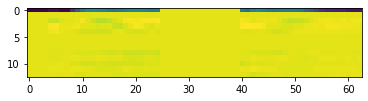

In [ ]:
plt.imshow(audio[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


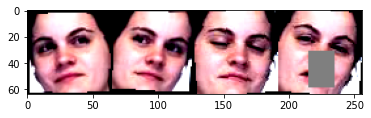

In [ ]:
plt.imshow(video[0].permute(1, 2, 0)/2 + 0.5)

In [ ]:
print(len(train_dataset), len(dev_dataset), len(test_dataset))
print(len(train_dataloader), len(dev_dataloader), len(test_dataloader))

5705 498 505
45 16 16


In [29]:
# audio model for our multimodal training
class BasicAudioRnnModel(torch.nn.Module):
  def __init__(self, input_size=128, hidden_size=512,num_layers=3, isBidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.linearIn = 2*hidden_size if isBidirectional else hidden_size
    self.rnn = torch.nn.GRU(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers,
                            batch_first=True, 
                            dropout = 0.3, #only for GRU and LSTM not for RNN
                            bidirectional=isBidirectional) #Test with unidirectional
    # self.linear = torch.nn.Linear(self.linearIn, num_classes) 
    self.out_shape = self.linearIn
  def forward(self, X):
    out, h = self.rnn(X)
    out_required = out[:, -1, :]
    # yhat = self.linear(out_required)
    return out_required

In [30]:
def get_padding_dims_same(in_height=64, in_width=64, filter_height=3, filter_width=3, strides=(None, 1, 1)):
    out_height = np.ceil(float(in_height) / float(strides[1]))
    out_width  = np.ceil(float(in_width) / float(strides[2]))

    if (in_height % strides[1] == 0): pad_along_height = max(filter_height - strides[1], 0)
    else: pad_along_height = max(filter_height - (in_height % strides[1]), 0)
    if (in_width % strides[2] == 0): pad_along_width = max(filter_width - strides[2], 0)
    else: pad_along_width = max(filter_width - (in_width % strides[2]), 0)
    pad_top = pad_along_height // 2; pad_bottom = pad_along_height - pad_top; pad_left = pad_along_width // 2
    pad_right = pad_along_width - pad_left
    return (pad_left + pad_right)//2, (pad_top + pad_bottom)//2
    return (pad_left, pad_right, pad_top, pad_bottom)

def get_output_size_convs(H, W, KW, KH, S, P):
    outputW = 1 + (W - KW + 2*P)//S
    outputH = 1 + (H - KH + 2*P)//S
    return outputW, outputH

In [31]:
class ResBlock(nn.Module):
    def __init__(self, W, H, params):
        super().__init__()
        self.params = params
        padding_dims1 = get_padding_dims_same(W, H, 
                                              params[0]['kernel_size'], 
                                              params[0]['kernel_size'],
                                              (None, params[0]['stride'], params[0]['stride']))
        self.conv1 = nn.Conv2d(params[0]['in_channels'], 
                               params[0]['out_channels'], 
                               kernel_size=params[0]['kernel_size'], 
                               stride=params[0]['stride'],
                               padding=padding_dims1)
        self.bn1 = nn.BatchNorm2d(params[0]['out_channels'])
        self.relu = nn.ReLU()
        
        padding_dims2 = get_padding_dims_same(W, H, 
                                              params[0]['kernel_size'], 
                                              params[0]['kernel_size'],
                                              (None, params[0]['stride'], params[0]['stride']))
        
        
        self.conv2 = nn.Conv2d(params[1]['in_channels'], 
                               params[1]['out_channels'], 
                               kernel_size=params[1]['kernel_size'], 
                               stride=params[1]['stride'],
                               padding=padding_dims2)
        self.bn2 = nn.BatchNorm2d(params[1]['out_channels'])
        if params[1]['channel_resizer']:
            self.channel_resizer = nn.Conv2d(params[0]['in_channels'], params[1]['out_channels'], kernel_size=1, stride=1)
        else:
            self.channel_resizer = nn.Identity()
        
    def forward(self, X):
        IN = X
#         print("0", X.shape)
        
        out = self.conv1(X)
#         print("1", out.shape)
        
        out = self.bn1(out)
#         print("2", out.shape)
        
        out = self.relu(out)
#         print("3", out.shape)
        
        out = self.conv2(out)
#         print("4", out.shape)
        IN = self.channel_resizer(IN)
#         print("5", IN.shape)
        
        out += IN
#         print("6", out.shape)
        return self.relu(out)

    
class NormalConvBlock(nn.Module):
    def __init__(self, W=64, H=64, params=None):
        super().__init__()
        self.params = params
        self.W = W
        self.H = H
        self.conv1 = nn.Conv2d(params['in_channels'], 
                               params['out_channels'],
                              kernel_size=params['kernel_size'],
                              stride=params['stride'])
        self.pool = nn.AvgPool2d(kernel_size=params['pool_kernel_size'], 
                                   stride=params['pool_stride'])
        self.relu = nn.ReLU()

    def forward(self, X):
        out = self.conv1(X)
        out = self.pool(out)
        out = self.relu(out)
        return out
    def get_output_size(self):
        w, h = get_output_size_convs(self.W, self.H, 
                                     self.params['kernel_size'], self.params['kernel_size'],
                                     self.params['stride'], 0)
        w, h = get_output_size_convs(w, h, 
                                     self.params['pool_kernel_size'], self.params['pool_kernel_size'],
                                     self.params['pool_stride'], 0)
        return self.params['out_channels'], w, h


class MyVideoSimpleModel(nn.Module):
    def __init__(self, W=64, H=64, hyperparameters=None, classes=4000):
        super().__init__()
        normal_params = hyperparameters['normal_params']
        resnet_params = hyperparameters['resnet_params']
        n_resnet_blocks = hyperparameters['n_resnet_blocks']
        
        layers = []
        
        w, h = W, H
        for i, n_params in enumerate(normal_params):
            layers.append(NormalConvBlock(w, h, n_params))
            c, w, h = layers[-1].get_output_size()
            print(c, w, h)
            
        print(f"Normal Inputs to ResBlocks: W: {w} H: {h}")
        
        for i in range(n_resnet_blocks):
            layers.append(ResBlock(W, H, resnet_params))
        
        self.net = nn.Sequential(*layers)
        self.flatten = nn.Flatten()
        
        self.out_shape = c*w*h
        
        # self.linear1 = nn.Linear(c*w*h, 1500)
        # self.tanh = nn.Tanh()
        # self.linear2 = nn.Linear(1500, classes)

    def forward(self, X, form='nlwc', return_bn=False):
        if form=='nlwc':
            X = X.permute(0, 3, 1, 2)
        out = self.net(X)
        out = self.flatten(out)
        # out = self.linear1(out)
        # out = self.tanh(out)
        # self.bottlenecks = out
        # out = self.linear2(out)
        # if return_bn: 
        #         return out, self.bottlenecks
        return out

In [32]:
class AudioVideoMMmodel5V1(nn.Module):
    def __init__(self, audio_hyperparameters, video_hyperparameters, classes=8, layer_emb=2000):
        super().__init__()
        self.audio_model = BasicAudioRnnModel(audio_hyperparameters['INPUT_SIZE'], 
                                              audio_hyperparameters['N_HIDDEN'], 
                                              audio_hyperparameters['NUM_LAYERS'],  
                                              audio_hyperparameters['IS_BIDIRECTIONAL'])
        
        self.video_model = MyVideoSimpleModel(hyperparameters=video_hyperparameters, W=256, H=64)

        self.in_shape = self.audio_model.out_shape + self.video_model.out_shape
        
        print(f"Audio Vector Size: {self.audio_model.out_shape}\nVideo Vector Shape: {self.video_model.out_shape}\nConcatenated: {self.in_shape}")
        
        # audio classifier
        self.audio_classifier = torch.nn.Linear(self.audio_model.out_shape, classes)
        
        # video classifier
        self.video_classifier = torch.nn.Linear(self.video_model.out_shape, classes)

        self.dropout1 = torch.nn.Dropout()
        self.dropout2 = torch.nn.Dropout()

        # audio video classifier
        self.linear_layer = torch.nn.Linear(self.in_shape, layer_emb)
        self.relu_final = torch.nn.ReLU()
        self.final_classifier = torch.nn.Linear(layer_emb, classes)

    def forward(self, audio, video, verbose=False):
      audio_out = self.dropout1(self.audio_model(audio))
      video_out = self.dropout2(self.video_model(video, form='nclw'))
      concatenated_vector = torch.cat([audio_out, video_out], dim=1)
      
      if verbose:
        print(f"Audio vector shape: {audio_out.shape}")
        print(f"Video vector shape: {video_out.shape}")
        print(f"Concatenated vector shape: {concatenated_vector.shape}")

      # audio classification
      out_a = self.audio_classifier(audio_out)
      # video classification
      out_v = self.video_classifier(video_out)

      # concatenated classification
      out_av = self.linear_layer(concatenated_vector)
      out_av = self.relu_final(out_av)
      out_av = self.final_classifier(out_av)
      return out_av, out_a, out_v

In [33]:
# hyperparameters of my model for easy versioning is stored in a dictionary and later into a yaml file. 

# video model
normal_params = [{'in_channels':3, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2}]

resnet_params = [{'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'channel_resizer':False},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'channel_resizer':False}]
n_resnet_blocks = 5

video_hyperparameters = {'normal_params':normal_params,
                   'resnet_params':resnet_params,
                   'n_resnet_blocks':n_resnet_blocks}

# audio hyperparameters
audio_hyperparameters = {
    'INPUT_SIZE': 13,
    'N_HIDDEN': 512,
    'NUM_LAYERS':3,
    'IS_BIDIRECTIONAL': True
}

full_hyperparameters = {'audio_hyperparameters': audio_hyperparameters, 
                        'video_hyperparameters': video_hyperparameters}        

In [34]:
# audio.shape, video.shape, label.shape
full_hyperparameters

{'audio_hyperparameters': {'INPUT_SIZE': 13,
  'IS_BIDIRECTIONAL': True,
  'NUM_LAYERS': 3,
  'N_HIDDEN': 512},
 'video_hyperparameters': {'n_resnet_blocks': 5,
  'normal_params': [{'in_channels': 3,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1},
   {'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1},
   {'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1},
   {'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1}],
  'resnet_params': [{'channel_resizer': False,
    'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'stride': 1},
   {'channel_resizer': False,
    'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'stride': 1}]}}

In [35]:
DEVICE = 'cuda'

In [36]:
av_model_5 = AudioVideoMMmodel5V1(audio_hyperparameters, video_hyperparameters)
av_model_5.to(DEVICE)

128 127 31
128 62 14
128 30 6
128 14 2
Normal Inputs to ResBlocks: W: 14 H: 2
Audio Vector Size: 1024
Video Vector Shape: 3584
Concatenated: 4608


AudioVideoMMmodel5V1(
  (audio_model): BasicAudioRnnModel(
    (rnn): GRU(13, 512, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  )
  (video_model): MyVideoSimpleModel(
    (net): Sequential(
      (0): NormalConvBlock(
        (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (1): NormalConvBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (2): NormalConvBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (3): NormalConvBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (4): ResBlock(
        (

In [37]:
av_model_5.load_state_dict(torch.load('/content/drive/MyDrive/Projects/PatternModels/FinalGoodModel/model.pth').state_dict())

<All keys matched successfully>

In [38]:
# outs = av_model_3(audio.permute(0, 2, 1), video, verbose=True)

In [39]:
# outs.shape

In [40]:
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(av_model_5.parameters(), lr=0.001) #initial lr=0.01
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=2)

In [41]:
def get_accuracy(yhat, y):
  return (yhat.argmax(1)==y).float().mean()


def train_one_epoch_audiovideov5(model, dataset, criterion, optim, epoch):
  model.train()
  losses = []
  lossesav = []
  lossesa = []
  lossesv = []
  accus = []
  accusa = []
  accusv = []
  stime = time.time()
  pbar = tqdm(dataset)
  for i, batch in enumerate(pbar):
    audiofeats = batch[0].to(DEVICE)
    videofeats = batch[1].to(DEVICE)
    labels = batch[2].flatten().to(DEVICE)

    outs_av, outs_a, outs_v = model(torch.permute(audiofeats, (0, 2, 1)), videofeats)

    optim.zero_grad()
    
    l_av = criterion(outs_av, labels.long())
    l_a = criterion(outs_a, labels.long())
    l_v = criterion(outs_v, labels.long())

    l = 0.5*l_av + 0.25*l_a + 0.25*l_v

    l.backward()
    optim.step()

    # updating all the loss terms
    losses.append(l.item())
    lossesav.append(l_av.item()) # AV
    lossesa.append(l_a.item()) # A
    lossesv.append(l_v.item()) # V
    # AV accuracy
    accu = get_accuracy(outs_av, labels)
    accus.append(accu.item())
    # A accuracy
    accua = get_accuracy(outs_a, labels)
    accusa.append(accua.item())
    # V accuracy
    accuv = get_accuracy(outs_v, labels)
    accusv.append(accuv.item())

    accuracy_avg = sum(accus)/len(accus)
    accuracy_a_avg = sum(accusa)/len(accusa)
    accuracy_v_avg = sum(accusv)/len(accusv)
    loss_avg = sum(losses)/len(losses)
    loss_av_avg = sum(lossesav)/len(lossesav)
    loss_a_avg = sum(lossesa)/len(lossesa)
    loss_v_avg = sum(lossesv)/len(lossesv)
    pbar.set_description(f"Prog-AccuAV: {accuracy_avg:.3f}\tAccuA: {accuracy_a_avg:.3f}\tAccuV: {accuracy_v_avg:.3f}\tLoss: {loss_avg:.3f}\tLoss_av: {loss_av_avg:.3f}\tLoss_a: {loss_a_avg:.3f}\tLoss_v: {loss_v_avg:.3f}")

  etime = time.time()
  accuracy_avg = sum(accus)/len(accus)
  loss_avg = sum(losses)/len(losses)
  time_total = etime - stime
  print(f'\n[TRAIN] Epoch: {epoch}\tAccu: {accuracy_avg}\tLoss: {loss_avg}\tTime: {time_total:.3f} secs')
  return loss_avg, accuracy_avg, time_total

@torch.no_grad()
def evaluate_model(model, dataset, criterion, epoch, subset='VALID'):
  model.eval()
  losses = []
  lossesav = []
  lossesa = []
  lossesv = []
  accus = []
  accusa = []
  accusv = []
  stime = time.time()
  for i, batch in enumerate(dataset):
    audiofeats = batch[0].to(DEVICE)
    videofeats = batch[1].to(DEVICE)
    labels = batch[2].flatten().to(DEVICE)

    outs_av, outs_a, outs_v = model(torch.permute(audiofeats, (0, 2, 1)), videofeats)
    
    l_av = criterion(outs_av, labels.long())
    l_a = criterion(outs_a, labels.long())
    l_v = criterion(outs_v, labels.long())

    l = 0.5*l_av + 0.25*l_a + 0.25*l_v

    # updating all the loss terms
    losses.append(l.item())
    lossesav.append(l_av.item()) # AV
    lossesa.append(l_a.item()) # A
    lossesv.append(l_v.item()) # V
    # AV accuracy
    accu = get_accuracy(outs_av, labels)
    accus.append(accu.item())
    # A accuracy
    accua = get_accuracy(outs_a, labels)
    accusa.append(accua.item())
    # V accuracy
    accuv = get_accuracy(outs_v, labels)
    accusv.append(accuv.item())
  etime = time.time()
  
  accuracy_avg = sum(accus)/len(accus)
  accuracy_a_avg = sum(accusa)/len(accusa)
  accuracy_v_avg = sum(accusv)/len(accusv)
  loss_avg = sum(losses)/len(losses)
  loss_av_avg = sum(lossesav)/len(lossesav)
  loss_a_avg = sum(lossesa)/len(lossesa)
  loss_v_avg = sum(lossesv)/len(lossesv)

  time_total = etime - stime
  print(f'[{subset:5}] Epoch: {epoch}\tAccu: {accuracy_avg}\tLoss: {loss_avg}\tTime: {time_total:.3f} secs; ---> AccuAu: {accuracy_a_avg:.3f}\tAccuVd: {accuracy_v_avg:.3f}')
  return loss_avg, accuracy_avg, time_total

In [42]:
# res = train_one_epoch_audiovideov5(av_model_5, train_dataloader, criterion, optim, epoch=1)
# res_dv = evaluate_model(av_model_5, dev_dataloader, criterion, epoch=1)

In [43]:
# res_dv = evaluate_model(av_model_5, dev_dataloader, criterion, epoch=1)

In [44]:
get_lr = lambda optim: optim.param_groups[0]['lr']

In [ ]:
N_EPOCHS = 50
for epoch in range(1, N_EPOCHS + 1):
  # training the model for one epoch
  print(f"Starting Training epoch: {epoch}")
  train_loss_avg, train_accuracy_avg, train_time_total = train_one_epoch_audiovideov5(av_model_5, train_dataloader, criterion, optim, epoch)

  # evaluate the model one epoch
  dev_loss_avg, dev_accuracy_avg, dev_time_total = evaluate_model(av_model_5, dev_dataloader, criterion, epoch)
  test_loss_avg, test_accuracy_avg, test_time_total = evaluate_model(av_model_5, test_dataloader, criterion, epoch, 'TEST')
  # scheduler
  scheduler.step(dev_loss_avg)
  print(f"Learning rate at epoch: {epoch} is {get_lr(optim)}\n")

Starting Training epoch: 1


Prog-AccuAV: 0.295	AccuA: 0.278	AccuV: 0.188	Loss: 1.916	Loss_av: 1.903	Loss_a: 1.838	Loss_v: 2.021: 100%|██████████| 45/45 [00:18<00:00,  2.42it/s]


[TRAIN] Epoch: 1	Accu: 0.29537671208381655	Loss: 1.9161500400967069	Time: 18.599 secs


[VALID] Epoch: 1	Accu: 0.396484375	Loss: 1.692574642598629	Time: 1.345 secs; ---> AccuAu: 0.333	AccuVd: 0.240
[TEST ] Epoch: 1	Accu: 0.4060937501490116	Loss: 1.7079972475767136	Time: 1.463 secs; ---> AccuAu: 0.367	AccuVd: 0.242
Learning rate at epoch: 1 is 0.001

Starting Training epoch: 2


Prog-AccuAV: 0.444	AccuA: 0.362	AccuV: 0.261	Loss: 1.603	Loss_av: 1.468	Loss_a: 1.632	Loss_v: 1.847: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


[TRAIN] Epoch: 2	Accu: 0.44433266719182335	Loss: 1.603350732061598	Time: 18.304 secs


[VALID] Epoch: 2	Accu: 0.5523003488779068	Loss: 1.3888316005468369	Time: 1.386 secs; ---> AccuAu: 0.418	AccuVd: 0.336
[TEST ] Epoch: 2	Accu: 0.5210156254470348	Loss: 1.4795679226517677	Time: 1.401 secs; ---> AccuAu: 0.439	AccuVd: 0.319
Learning rate at epoch: 2 is 0.001

Starting Training epoch: 3


Prog-AccuAV: 0.499	AccuA: 0.380	AccuV: 0.322	Loss: 1.498	Loss_av: 1.336	Loss_a: 1.588	Loss_v: 1.731: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


[TRAIN] Epoch: 3	Accu: 0.4994125763575236	Loss: 1.4976287894778781	Time: 18.122 secs


[VALID] Epoch: 3	Accu: 0.6338975690305233	Loss: 1.2615699768066406	Time: 1.435 secs; ---> AccuAu: 0.440	AccuVd: 0.391
[TEST ] Epoch: 3	Accu: 0.621171873062849	Loss: 1.3213689625263214	Time: 1.430 secs; ---> AccuAu: 0.447	AccuVd: 0.391
Learning rate at epoch: 3 is 0.001

Starting Training epoch: 4


Prog-AccuAV: 0.558	AccuA: 0.407	AccuV: 0.338	Loss: 1.374	Loss_av: 1.173	Loss_a: 1.508	Loss_v: 1.643: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


[TRAIN] Epoch: 4	Accu: 0.5577934741973877	Loss: 1.3744516928990682	Time: 18.234 secs


[VALID] Epoch: 4	Accu: 0.662109375	Loss: 1.1862998232245445	Time: 1.367 secs; ---> AccuAu: 0.421	AccuVd: 0.424
[TEST ] Epoch: 4	Accu: 0.6442968733608723	Loss: 1.2229683250188828	Time: 1.447 secs; ---> AccuAu: 0.490	AccuVd: 0.379
Learning rate at epoch: 4 is 0.001

Starting Training epoch: 5


Prog-AccuAV: 0.598	AccuA: 0.431	AccuV: 0.383	Loss: 1.277	Loss_av: 1.057	Loss_a: 1.443	Loss_v: 1.551: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


[TRAIN] Epoch: 5	Accu: 0.5980308214823405	Loss: 1.2767281240887112	Time: 18.258 secs


[VALID] Epoch: 5	Accu: 0.6221788190305233	Loss: 1.2206626683473587	Time: 1.418 secs; ---> AccuAu: 0.461	AccuVd: 0.374
[TEST ] Epoch: 5	Accu: 0.6339843720197678	Loss: 1.2831636518239975	Time: 1.359 secs; ---> AccuAu: 0.459	AccuVd: 0.388
Learning rate at epoch: 5 is 0.001

Starting Training epoch: 6


Prog-AccuAV: 0.626	AccuA: 0.454	AccuV: 0.413	Loss: 1.210	Loss_av: 0.983	Loss_a: 1.389	Loss_v: 1.487: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


[TRAIN] Epoch: 6	Accu: 0.6257229831483629	Loss: 1.2104112095303006	Time: 18.155 secs


[VALID] Epoch: 6	Accu: 0.6781684029847383	Loss: 1.12353989854455	Time: 1.439 secs; ---> AccuAu: 0.465	AccuVd: 0.465
[TEST ] Epoch: 6	Accu: 0.650468748062849	Loss: 1.2239450439810753	Time: 1.480 secs; ---> AccuAu: 0.484	AccuVd: 0.408
Learning rate at epoch: 6 is 0.001

Starting Training epoch: 7


Prog-AccuAV: 0.648	AccuA: 0.462	AccuV: 0.419	Loss: 1.160	Loss_av: 0.919	Loss_a: 1.357	Loss_v: 1.447: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


[TRAIN] Epoch: 7	Accu: 0.6482924275928074	Loss: 1.1604295545154149	Time: 18.254 secs


[VALID] Epoch: 7	Accu: 0.7315538190305233	Loss: 1.0224946774542332	Time: 1.415 secs; ---> AccuAu: 0.510	AccuVd: 0.465
[TEST ] Epoch: 7	Accu: 0.6892968751490116	Loss: 1.006367526948452	Time: 1.418 secs; ---> AccuAu: 0.547	AccuVd: 0.462
Learning rate at epoch: 7 is 0.001

Starting Training epoch: 8


Prog-AccuAV: 0.684	AccuA: 0.479	AccuV: 0.438	Loss: 1.114	Loss_av: 0.861	Loss_a: 1.342	Loss_v: 1.392: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


[TRAIN] Epoch: 8	Accu: 0.6835830476548936	Loss: 1.1142159859339396	Time: 18.263 secs


[VALID] Epoch: 8	Accu: 0.7562934029847383	Loss: 0.9914581589400768	Time: 1.416 secs; ---> AccuAu: 0.503	AccuVd: 0.484
[TEST ] Epoch: 8	Accu: 0.7667968720197678	Loss: 0.9760139957070351	Time: 1.427 secs; ---> AccuAu: 0.555	AccuVd: 0.486
Learning rate at epoch: 8 is 0.001

Starting Training epoch: 9


Prog-AccuAV: 0.714	AccuA: 0.501	AccuV: 0.445	Loss: 1.038	Loss_av: 0.763	Loss_a: 1.264	Loss_v: 1.362: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


[TRAIN] Epoch: 9	Accu: 0.7139174275928073	Loss: 1.0383579095204671	Time: 18.210 secs


[VALID] Epoch: 9	Accu: 0.7523871529847383	Loss: 0.9114589020609856	Time: 1.428 secs; ---> AccuAu: 0.590	AccuVd: 0.514
[TEST ] Epoch: 9	Accu: 0.7360937483608723	Loss: 1.0067654959857464	Time: 1.445 secs; ---> AccuAu: 0.617	AccuVd: 0.463
Learning rate at epoch: 9 is 0.001

Starting Training epoch: 10


Prog-AccuAV: 0.707	AccuA: 0.503	AccuV: 0.465	Loss: 1.042	Loss_av: 0.776	Loss_a: 1.276	Loss_v: 1.339: 100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


[TRAIN] Epoch: 10	Accu: 0.7072393457094829	Loss: 1.041996881696913	Time: 18.357 secs


[VALID] Epoch: 10	Accu: 0.7447916679084301	Loss: 0.9310522675514221	Time: 1.434 secs; ---> AccuAu: 0.567	AccuVd: 0.513
[TEST ] Epoch: 10	Accu: 0.7503124997019768	Loss: 0.9186890795826912	Time: 1.425 secs; ---> AccuAu: 0.578	AccuVd: 0.503
Learning rate at epoch: 10 is 0.001

Starting Training epoch: 11


Prog-AccuAV: 0.753	AccuA: 0.527	AccuV: 0.486	Loss: 0.952	Loss_av: 0.665	Loss_a: 1.208	Loss_v: 1.270: 100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


[TRAIN] Epoch: 11	Accu: 0.7531582951545716	Loss: 0.9521444492869907	Time: 18.386 secs


[VALID] Epoch: 11	Accu: 0.7510850690305233	Loss: 0.9381332360208035	Time: 1.414 secs; ---> AccuAu: 0.577	AccuVd: 0.484
[TEST ] Epoch: 11	Accu: 0.7374999970197678	Loss: 0.93250996991992	Time: 1.388 secs; ---> AccuAu: 0.556	AccuVd: 0.503
Learning rate at epoch: 11 is 0.001

Starting Training epoch: 12


Prog-AccuAV: 0.748	AccuA: 0.532	AccuV: 0.498	Loss: 0.944	Loss_av: 0.662	Loss_a: 1.194	Loss_v: 1.260: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


[TRAIN] Epoch: 12	Accu: 0.7476455476548937	Loss: 0.944456919034322	Time: 18.168 secs


[VALID] Epoch: 12	Accu: 0.7697482630610466	Loss: 0.9146877229213715	Time: 1.449 secs; ---> AccuAu: 0.580	AccuVd: 0.442
[TEST ] Epoch: 12	Accu: 0.7489843741059303	Loss: 0.8638920709490776	Time: 1.410 secs; ---> AccuAu: 0.601	AccuVd: 0.476
Learning rate at epoch: 12 is 0.0005

Starting Training epoch: 13


Prog-AccuAV: 0.824	AccuA: 0.587	AccuV: 0.544	Loss: 0.789	Loss_av: 0.483	Loss_a: 1.058	Loss_v: 1.129: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


[TRAIN] Epoch: 13	Accu: 0.8238655818833245	Loss: 0.7886112385325962	Time: 18.241 secs


[VALID] Epoch: 13	Accu: 0.8331163190305233	Loss: 0.799941461533308	Time: 1.426 secs; ---> AccuAu: 0.663	AccuVd: 0.574
[TEST ] Epoch: 13	Accu: 0.8382031247019768	Loss: 0.7250959929078817	Time: 1.431 secs; ---> AccuAu: 0.639	AccuVd: 0.579
Learning rate at epoch: 13 is 0.0005

Starting Training epoch: 14


Prog-AccuAV: 0.834	AccuA: 0.603	AccuV: 0.559	Loss: 0.757	Loss_av: 0.448	Loss_a: 1.022	Loss_v: 1.109: 100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


[TRAIN] Epoch: 14	Accu: 0.8342370616065131	Loss: 0.7566663742065429	Time: 18.352 secs


[VALID] Epoch: 14	Accu: 0.8381076380610466	Loss: 0.7152086161077023	Time: 1.424 secs; ---> AccuAu: 0.666	AccuVd: 0.586
[TEST ] Epoch: 14	Accu: 0.8415624983608723	Loss: 0.6767139863222837	Time: 1.409 secs; ---> AccuAu: 0.622	AccuVd: 0.618
Learning rate at epoch: 14 is 0.0005

Starting Training epoch: 15


Prog-AccuAV: 0.847	AccuA: 0.614	AccuV: 0.575	Loss: 0.727	Loss_av: 0.422	Loss_a: 0.986	Loss_v: 1.077: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


[TRAIN] Epoch: 15	Accu: 0.8469962901539273	Loss: 0.7265171554353502	Time: 18.163 secs


[VALID] Epoch: 15	Accu: 0.8029513880610466	Loss: 0.7493860218673944	Time: 1.402 secs; ---> AccuAu: 0.643	AccuVd: 0.562
[TEST ] Epoch: 15	Accu: 0.8056249991059303	Loss: 0.7651048079133034	Time: 1.485 secs; ---> AccuAu: 0.610	AccuVd: 0.604
Learning rate at epoch: 15 is 0.0005

Starting Training epoch: 16


Prog-AccuAV: 0.858	AccuA: 0.649	AccuV: 0.603	Loss: 0.679	Loss_av: 0.380	Loss_a: 0.925	Loss_v: 1.030: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


[TRAIN] Epoch: 16	Accu: 0.8580693496598137	Loss: 0.6786369999249776	Time: 18.249 secs


[VALID] Epoch: 16	Accu: 0.8589409738779068	Loss: 0.687602836638689	Time: 1.454 secs; ---> AccuAu: 0.661	AccuVd: 0.616
[TEST ] Epoch: 16	Accu: 0.8649999983608723	Loss: 0.6512525863945484	Time: 1.417 secs; ---> AccuAu: 0.630	AccuVd: 0.664
Learning rate at epoch: 16 is 0.0005

Starting Training epoch: 17


Prog-AccuAV: 0.874	AccuA: 0.656	AccuV: 0.629	Loss: 0.638	Loss_av: 0.345	Loss_a: 0.887	Loss_v: 0.977: 100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


[TRAIN] Epoch: 17	Accu: 0.8735635466045804	Loss: 0.6383805923991733	Time: 18.379 secs


[VALID] Epoch: 17	Accu: 0.8702256940305233	Loss: 0.700712775811553	Time: 1.373 secs; ---> AccuAu: 0.683	AccuVd: 0.588
[TEST ] Epoch: 17	Accu: 0.8440624997019768	Loss: 0.6968208905309439	Time: 1.387 secs; ---> AccuAu: 0.666	AccuVd: 0.653
Learning rate at epoch: 17 is 0.0005

Starting Training epoch: 18


Prog-AccuAV: 0.878	AccuA: 0.666	AccuV: 0.628	Loss: 0.623	Loss_av: 0.334	Loss_a: 0.870	Loss_v: 0.955: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


[TRAIN] Epoch: 18	Accu: 0.8775114152166579	Loss: 0.6229270842340258	Time: 18.174 secs


[VALID] Epoch: 18	Accu: 0.73046875	Loss: 1.0679220594465733	Time: 1.413 secs; ---> AccuAu: 0.706	AccuVd: 0.539
[TEST ] Epoch: 18	Accu: 0.7450781241059303	Loss: 0.923499658703804	Time: 1.437 secs; ---> AccuAu: 0.646	AccuVd: 0.571
Learning rate at epoch: 18 is 0.0005

Starting Training epoch: 19


Prog-AccuAV: 0.885	AccuA: 0.674	AccuV: 0.644	Loss: 0.609	Loss_av: 0.318	Loss_a: 0.858	Loss_v: 0.942: 100%|██████████| 45/45 [00:18<00:00,  2.44it/s]


[TRAIN] Epoch: 19	Accu: 0.8848030818833246	Loss: 0.6087145302030775	Time: 18.464 secs


[VALID] Epoch: 19	Accu: 0.8752170130610466	Loss: 0.6113677397370338	Time: 1.368 secs; ---> AccuAu: 0.698	AccuVd: 0.659
[TEST ] Epoch: 19	Accu: 0.8491406254470348	Loss: 0.6193986423313618	Time: 1.386 secs; ---> AccuAu: 0.673	AccuVd: 0.673
Learning rate at epoch: 19 is 0.0005

Starting Training epoch: 20


Prog-AccuAV: 0.890	AccuA: 0.673	AccuV: 0.660	Loss: 0.583	Loss_av: 0.296	Loss_a: 0.850	Loss_v: 0.890: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


[TRAIN] Epoch: 20	Accu: 0.8904062019454109	Loss: 0.5829719245433808	Time: 18.114 secs


[VALID] Epoch: 20	Accu: 0.8849826380610466	Loss: 0.6432209555059671	Time: 1.453 secs; ---> AccuAu: 0.672	AccuVd: 0.663
[TEST ] Epoch: 20	Accu: 0.8834374994039536	Loss: 0.5792602505534887	Time: 1.464 secs; ---> AccuAu: 0.652	AccuVd: 0.701
Learning rate at epoch: 20 is 0.0005

Starting Training epoch: 21


Prog-AccuAV: 0.904	AccuA: 0.695	AccuV: 0.673	Loss: 0.551	Loss_av: 0.270	Loss_a: 0.803	Loss_v: 0.861: 100%|██████████| 45/45 [00:18<00:00,  2.43it/s]


[TRAIN] Epoch: 21	Accu: 0.9040762941042583	Loss: 0.5510362452930875	Time: 18.494 secs


[VALID] Epoch: 21	Accu: 0.8346354179084301	Loss: 0.7172696813941002	Time: 1.398 secs; ---> AccuAu: 0.726	AccuVd: 0.594
[TEST ] Epoch: 21	Accu: 0.8767187483608723	Loss: 0.6803323142230511	Time: 1.419 secs; ---> AccuAu: 0.684	AccuVd: 0.637
Learning rate at epoch: 21 is 0.0005

Starting Training epoch: 22


Prog-AccuAV: 0.900	AccuA: 0.701	AccuV: 0.684	Loss: 0.544	Loss_av: 0.275	Loss_a: 0.782	Loss_v: 0.843: 100%|██████████| 45/45 [00:18<00:00,  2.44it/s]


[TRAIN] Epoch: 22	Accu: 0.900168854660458	Loss: 0.5435945338673062	Time: 18.421 secs


[VALID] Epoch: 22	Accu: 0.8674045130610466	Loss: 0.6928510665893555	Time: 1.382 secs; ---> AccuAu: 0.701	AccuVd: 0.663
[TEST ] Epoch: 22	Accu: 0.864140622317791	Loss: 0.6789868399500847	Time: 1.392 secs; ---> AccuAu: 0.705	AccuVd: 0.629
Learning rate at epoch: 22 is 0.00025

Starting Training epoch: 23


Prog-AccuAV: 0.926	AccuA: 0.723	AccuV: 0.718	Loss: 0.479	Loss_av: 0.206	Loss_a: 0.737	Loss_v: 0.765: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


[TRAIN] Epoch: 23	Accu: 0.9261249052153693	Loss: 0.47859702441427443	Time: 18.236 secs


[VALID] Epoch: 23	Accu: 0.9006076380610466	Loss: 0.5477123614400625	Time: 1.414 secs; ---> AccuAu: 0.734	AccuVd: 0.682
[TEST ] Epoch: 23	Accu: 0.891484372317791	Loss: 0.5527586285024881	Time: 1.428 secs; ---> AccuAu: 0.707	AccuVd: 0.715
Learning rate at epoch: 23 is 0.00025

Starting Training epoch: 24


Prog-AccuAV: 0.931	AccuA: 0.729	AccuV: 0.731	Loss: 0.452	Loss_av: 0.188	Loss_a: 0.707	Loss_v: 0.726: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


[TRAIN] Epoch: 24	Accu: 0.9305103686120775	Loss: 0.4523294972048865	Time: 18.324 secs


[VALID] Epoch: 24	Accu: 0.9162326380610466	Loss: 0.5376461688429117	Time: 1.465 secs; ---> AccuAu: 0.735	AccuVd: 0.737
[TEST ] Epoch: 24	Accu: 0.8982031233608723	Loss: 0.5380825558677316	Time: 1.468 secs; ---> AccuAu: 0.751	AccuVd: 0.733
Learning rate at epoch: 24 is 0.00025

Starting Training epoch: 25


Prog-AccuAV: 0.934	AccuA: 0.744	AccuV: 0.734	Loss: 0.429	Loss_av: 0.171	Loss_a: 0.662	Loss_v: 0.712: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


[TRAIN] Epoch: 25	Accu: 0.9338945971594916	Loss: 0.42922770579655967	Time: 18.221 secs


[VALID] Epoch: 25	Accu: 0.8986545130610466	Loss: 0.5907895565032959	Time: 1.406 secs; ---> AccuAu: 0.709	AccuVd: 0.726
[TEST ] Epoch: 25	Accu: 0.895390622317791	Loss: 0.5653262883424759	Time: 1.388 secs; ---> AccuAu: 0.707	AccuVd: 0.718
Learning rate at epoch: 25 is 0.00025

Starting Training epoch: 26


Prog-AccuAV: 0.942	AccuA: 0.755	AccuV: 0.751	Loss: 0.413	Loss_av: 0.164	Loss_a: 0.649	Loss_v: 0.673: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


[TRAIN] Epoch: 26	Accu: 0.9422707385487027	Loss: 0.41275385088390776	Time: 18.161 secs


[VALID] Epoch: 26	Accu: 0.9006076380610466	Loss: 0.5437346287071705	Time: 1.462 secs; ---> AccuAu: 0.751	AccuVd: 0.714
[TEST ] Epoch: 26	Accu: 0.8939843736588955	Loss: 0.5580462496727705	Time: 1.398 secs; ---> AccuAu: 0.725	AccuVd: 0.716
Learning rate at epoch: 26 is 0.00025

Starting Training epoch: 27


Prog-AccuAV: 0.947	AccuA: 0.764	AccuV: 0.761	Loss: 0.399	Loss_av: 0.153	Loss_a: 0.629	Loss_v: 0.659: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


[TRAIN] Epoch: 27	Accu: 0.9466133938895331	Loss: 0.3986192537678613	Time: 18.332 secs


[VALID] Epoch: 27	Accu: 0.9084201380610466	Loss: 0.5299126133322716	Time: 1.438 secs; ---> AccuAu: 0.736	AccuVd: 0.731
[TEST ] Epoch: 27	Accu: 0.9001562483608723	Loss: 0.51505505759269	Time: 1.430 secs; ---> AccuAu: 0.730	AccuVd: 0.739
Learning rate at epoch: 27 is 0.00025

Starting Training epoch: 28


Prog-AccuAV: 0.945	AccuA: 0.771	AccuV: 0.760	Loss: 0.393	Loss_av: 0.151	Loss_a: 0.618	Loss_v: 0.652: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


[TRAIN] Epoch: 28	Accu: 0.9450508938895331	Loss: 0.393197892109553	Time: 18.193 secs


[VALID] Epoch: 28	Accu: 0.8967013880610466	Loss: 0.5374425016343594	Time: 1.428 secs; ---> AccuAu: 0.766	AccuVd: 0.723
[TEST ] Epoch: 28	Accu: 0.8987499997019768	Loss: 0.519240059889853	Time: 1.494 secs; ---> AccuAu: 0.749	AccuVd: 0.720
Learning rate at epoch: 28 is 0.00025

Starting Training epoch: 29


Prog-AccuAV: 0.952	AccuA: 0.789	AccuV: 0.780	Loss: 0.362	Loss_av: 0.132	Loss_a: 0.579	Loss_v: 0.608: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


[TRAIN] Epoch: 29	Accu: 0.951690924167633	Loss: 0.3624533348613315	Time: 18.249 secs


[VALID] Epoch: 29	Accu: 0.9240451380610466	Loss: 0.5246184980496764	Time: 1.430 secs; ---> AccuAu: 0.763	AccuVd: 0.768
[TEST ] Epoch: 29	Accu: 0.9076562486588955	Loss: 0.5574719049036503	Time: 1.442 secs; ---> AccuAu: 0.740	AccuVd: 0.743
Learning rate at epoch: 29 is 0.00025

Starting Training epoch: 30


Prog-AccuAV: 0.949	AccuA: 0.785	AccuV: 0.776	Loss: 0.369	Loss_av: 0.140	Loss_a: 0.583	Loss_v: 0.613: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


[TRAIN] Epoch: 30	Accu: 0.949129565556844	Loss: 0.3689331981870863	Time: 18.245 secs


[VALID] Epoch: 30	Accu: 0.8917100690305233	Loss: 0.5986090376973152	Time: 1.431 secs; ---> AccuAu: 0.754	AccuVd: 0.746
[TEST ] Epoch: 30	Accu: 0.8756249994039536	Loss: 0.5997529570013285	Time: 1.446 secs; ---> AccuAu: 0.751	AccuVd: 0.716
Learning rate at epoch: 30 is 0.00025

Starting Training epoch: 31


Prog-AccuAV: 0.955	AccuA: 0.793	AccuV: 0.785	Loss: 0.354	Loss_av: 0.123	Loss_a: 0.568	Loss_v: 0.600: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


[TRAIN] Epoch: 31	Accu: 0.9549015416039361	Loss: 0.3537766800986396	Time: 18.156 secs


[VALID] Epoch: 31	Accu: 0.9064670130610466	Loss: 0.5334375258535147	Time: 1.435 secs; ---> AccuAu: 0.744	AccuVd: 0.770
[TEST ] Epoch: 31	Accu: 0.8971093744039536	Loss: 0.5306748524308205	Time: 1.455 secs; ---> AccuAu: 0.733	AccuVd: 0.765
Learning rate at epoch: 31 is 0.00025

Starting Training epoch: 32


Prog-AccuAV: 0.955	AccuA: 0.792	AccuV: 0.791	Loss: 0.348	Loss_av: 0.127	Loss_a: 0.571	Loss_v: 0.569: 100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


[TRAIN] Epoch: 32	Accu: 0.9550775302780999	Loss: 0.3483858174747891	Time: 18.340 secs


[VALID] Epoch: 32	Accu: 0.9006076380610466	Loss: 0.6044866889715195	Time: 1.452 secs; ---> AccuAu: 0.742	AccuVd: 0.706
[TEST ] Epoch: 32	Accu: 0.8942968733608723	Loss: 0.5737508814781904	Time: 1.459 secs; ---> AccuAu: 0.728	AccuVd: 0.692
Learning rate at epoch: 32 is 0.000125

Starting Training epoch: 33


Prog-AccuAV: 0.964	AccuA: 0.808	AccuV: 0.807	Loss: 0.315	Loss_av: 0.101	Loss_a: 0.525	Loss_v: 0.534: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


[TRAIN] Epoch: 33	Accu: 0.9643645352787442	Loss: 0.3150944941573673	Time: 18.212 secs


[VALID] Epoch: 33	Accu: 0.9181857630610466	Loss: 0.47846963442862034	Time: 1.468 secs; ---> AccuAu: 0.756	AccuVd: 0.772
[TEST ] Epoch: 33	Accu: 0.9152343720197678	Loss: 0.4675598507747054	Time: 1.445 secs; ---> AccuAu: 0.782	AccuVd: 0.783
Learning rate at epoch: 33 is 0.000125

Starting Training epoch: 34


Prog-AccuAV: 0.969	AccuA: 0.806	AccuV: 0.821	Loss: 0.299	Loss_av: 0.089	Loss_a: 0.521	Loss_v: 0.497: 100%|██████████| 45/45 [00:18<00:00,  2.49it/s]


[TRAIN] Epoch: 34	Accu: 0.9693112638261583	Loss: 0.29879516296916536	Time: 18.071 secs


[VALID] Epoch: 34	Accu: 0.9103732630610466	Loss: 0.4996590977534652	Time: 1.443 secs; ---> AccuAu: 0.762	AccuVd: 0.770
[TEST ] Epoch: 34	Accu: 0.9274999983608723	Loss: 0.498270102776587	Time: 1.368 secs; ---> AccuAu: 0.764	AccuVd: 0.758
Learning rate at epoch: 34 is 0.000125

Starting Training epoch: 35


Prog-AccuAV: 0.967	AccuA: 0.819	AccuV: 0.826	Loss: 0.294	Loss_av: 0.087	Loss_a: 0.505	Loss_v: 0.496: 100%|██████████| 45/45 [00:18<00:00,  2.49it/s]


[TRAIN] Epoch: 35	Accu: 0.9669687019454108	Loss: 0.2940513557857937	Time: 18.065 secs


[VALID] Epoch: 35	Accu: 0.9123263880610466	Loss: 0.545159351080656	Time: 1.446 secs; ---> AccuAu: 0.771	AccuVd: 0.785
[TEST ] Epoch: 35	Accu: 0.897343747317791	Loss: 0.5872069280594587	Time: 1.425 secs; ---> AccuAu: 0.743	AccuVd: 0.766
Learning rate at epoch: 35 is 0.000125

Starting Training epoch: 36


Prog-AccuAV: 0.972	AccuA: 0.822	AccuV: 0.826	Loss: 0.282	Loss_av: 0.082	Loss_a: 0.484	Loss_v: 0.482: 100%|██████████| 45/45 [00:18<00:00,  2.43it/s]


[TRAIN] Epoch: 36	Accu: 0.9717441969447665	Loss: 0.28218829068872664	Time: 18.541 secs


[VALID] Epoch: 36	Accu: 0.9045138880610466	Loss: 0.5652671605348587	Time: 1.418 secs; ---> AccuAu: 0.764	AccuVd: 0.769
[TEST ] Epoch: 36	Accu: 0.9124218747019768	Loss: 0.5537299253046513	Time: 1.400 secs; ---> AccuAu: 0.745	AccuVd: 0.763
Learning rate at epoch: 36 is 6.25e-05

Starting Training epoch: 37


Prog-AccuAV: 0.972	AccuA: 0.827	AccuV: 0.836	Loss: 0.274	Loss_av: 0.077	Loss_a: 0.484	Loss_v: 0.461: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


[TRAIN] Epoch: 37	Accu: 0.9717870050006443	Loss: 0.27447174191474916	Time: 18.204 secs


[VALID] Epoch: 37	Accu: 0.9142795130610466	Loss: 0.49337156023830175	Time: 1.451 secs; ---> AccuAu: 0.766	AccuVd: 0.776
[TEST ] Epoch: 37	Accu: 0.9235937483608723	Loss: 0.4957372359931469	Time: 1.463 secs; ---> AccuAu: 0.795	AccuVd: 0.768
Learning rate at epoch: 37 is 6.25e-05

Starting Training epoch: 38


Prog-AccuAV: 0.977	AccuA: 0.832	AccuV: 0.835	Loss: 0.263	Loss_av: 0.068	Loss_a: 0.464	Loss_v: 0.451: 100%|██████████| 45/45 [00:18<00:00,  2.44it/s]


[TRAIN] Epoch: 38	Accu: 0.9766481161117554	Loss: 0.2628041452831692	Time: 18.413 secs


[VALID] Epoch: 38	Accu: 0.9103732630610466	Loss: 0.4945292165502906	Time: 1.460 secs; ---> AccuAu: 0.766	AccuVd: 0.787
[TEST ] Epoch: 38	Accu: 0.9157812483608723	Loss: 0.5032947398722172	Time: 1.365 secs; ---> AccuAu: 0.784	AccuVd: 0.791
Learning rate at epoch: 38 is 6.25e-05

Starting Training epoch: 39


Prog-AccuAV: 0.977	AccuA: 0.834	AccuV: 0.841	Loss: 0.264	Loss_av: 0.072	Loss_a: 0.461	Loss_v: 0.450: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


[TRAIN] Epoch: 39	Accu: 0.9765173130565219	Loss: 0.2635729389058219	Time: 18.187 secs


[VALID] Epoch: 39	Accu: 0.9162326380610466	Loss: 0.5086038913577795	Time: 1.420 secs; ---> AccuAu: 0.774	AccuVd: 0.801
[TEST ] Epoch: 39	Accu: 0.9205468744039536	Loss: 0.5155177917331457	Time: 1.435 secs; ---> AccuAu: 0.765	AccuVd: 0.801
Learning rate at epoch: 39 is 3.125e-05

Starting Training epoch: 40


Prog-AccuAV: 0.980	AccuA: 0.831	AccuV: 0.852	Loss: 0.248	Loss_av: 0.057	Loss_a: 0.458	Loss_v: 0.421: 100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


[TRAIN] Epoch: 40	Accu: 0.9798159241676331	Loss: 0.24818668630388047	Time: 18.373 secs


[VALID] Epoch: 40	Accu: 0.9123263880610466	Loss: 0.48726608976721764	Time: 1.439 secs; ---> AccuAu: 0.791	AccuVd: 0.793
[TEST ] Epoch: 40	Accu: 0.9177343733608723	Loss: 0.5018906267359853	Time: 1.461 secs; ---> AccuAu: 0.760	AccuVd: 0.797
Learning rate at epoch: 40 is 3.125e-05

Starting Training epoch: 41


Prog-AccuAV: 0.980	AccuA: 0.835	AccuV: 0.848	Loss: 0.246	Loss_av: 0.058	Loss_a: 0.444	Loss_v: 0.425: 100%|██████████| 45/45 [00:18<00:00,  2.44it/s]


[TRAIN] Epoch: 41	Accu: 0.9804247525003221	Loss: 0.24613756603664821	Time: 18.415 secs


[VALID] Epoch: 41	Accu: 0.9123263880610466	Loss: 0.48909364826977253	Time: 1.434 secs; ---> AccuAu: 0.784	AccuVd: 0.795
[TEST ] Epoch: 41	Accu: 0.9274999983608723	Loss: 0.48610532470047474	Time: 1.463 secs; ---> AccuAu: 0.779	AccuVd: 0.795
Learning rate at epoch: 41 is 3.125e-05

Starting Training epoch: 42


Prog-AccuAV: 0.977	AccuA: 0.842	AccuV: 0.849	Loss: 0.250	Loss_av: 0.064	Loss_a: 0.443	Loss_v: 0.429: 100%|██████████| 45/45 [00:18<00:00,  2.44it/s]


[TRAIN] Epoch: 42	Accu: 0.9771261413892111	Loss: 0.24982348084449768	Time: 18.425 secs


[VALID] Epoch: 42	Accu: 0.9181857630610466	Loss: 0.4941279198974371	Time: 1.409 secs; ---> AccuAu: 0.800	AccuVd: 0.797
[TEST ] Epoch: 42	Accu: 0.9299999997019768	Loss: 0.5033264681696892	Time: 1.438 secs; ---> AccuAu: 0.775	AccuVd: 0.803
Learning rate at epoch: 42 is 1.5625e-05

Starting Training epoch: 43


Prog-AccuAV: 0.979	AccuA: 0.841	AccuV: 0.849	Loss: 0.249	Loss_av: 0.064	Loss_a: 0.449	Loss_v: 0.417: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


[TRAIN] Epoch: 43	Accu: 0.9787314494450887	Loss: 0.24858859711223177	Time: 18.307 secs


[VALID] Epoch: 43	Accu: 0.9123263880610466	Loss: 0.48956194426864386	Time: 1.395 secs; ---> AccuAu: 0.784	AccuVd: 0.795
[TEST ] Epoch: 43	Accu: 0.9314062483608723	Loss: 0.4914109157398343	Time: 1.420 secs; ---> AccuAu: 0.791	AccuVd: 0.803
Learning rate at epoch: 43 is 1.5625e-05

Starting Training epoch: 44


Prog-AccuAV: 0.981	AccuA: 0.848	AccuV: 0.855	Loss: 0.237	Loss_av: 0.056	Loss_a: 0.437	Loss_v: 0.400: 100%|██████████| 45/45 [00:18<00:00,  2.44it/s]


[TRAIN] Epoch: 44	Accu: 0.9810763888888889	Loss: 0.2371495525042216	Time: 18.431 secs


[VALID] Epoch: 44	Accu: 0.9142795130610466	Loss: 0.47746645100414753	Time: 1.478 secs; ---> AccuAu: 0.780	AccuVd: 0.799
[TEST ] Epoch: 44	Accu: 0.9274999983608723	Loss: 0.4913973789662123	Time: 1.402 secs; ---> AccuAu: 0.775	AccuVd: 0.797
Learning rate at epoch: 44 is 1.5625e-05

Starting Training epoch: 45


Prog-AccuAV: 0.977	AccuA: 0.839	AccuV: 0.856	Loss: 0.245	Loss_av: 0.064	Loss_a: 0.439	Loss_v: 0.414: 100%|██████████| 45/45 [00:18<00:00,  2.49it/s]


[TRAIN] Epoch: 45	Accu: 0.9770381463898553	Loss: 0.24499241444799635	Time: 18.053 secs


[VALID] Epoch: 45	Accu: 0.9142795130610466	Loss: 0.4823124594986439	Time: 1.449 secs; ---> AccuAu: 0.778	AccuVd: 0.791
[TEST ] Epoch: 45	Accu: 0.9294531233608723	Loss: 0.49442297499626875	Time: 1.425 secs; ---> AccuAu: 0.777	AccuVd: 0.797
Learning rate at epoch: 45 is 1.5625e-05

Starting Training epoch: 46


Prog-AccuAV: 0.982	AccuA: 0.849	AccuV: 0.855	Loss: 0.237	Loss_av: 0.056	Loss_a: 0.422	Loss_v: 0.412: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


[TRAIN] Epoch: 46	Accu: 0.9822036716673109	Loss: 0.2366414768828286	Time: 18.126 secs


[VALID] Epoch: 46	Accu: 0.9162326380610466	Loss: 0.4830487435683608	Time: 1.426 secs; ---> AccuAu: 0.780	AccuVd: 0.799
[TEST ] Epoch: 46	Accu: 0.9339062497019768	Loss: 0.49163630697876215	Time: 1.394 secs; ---> AccuAu: 0.779	AccuVd: 0.799
Learning rate at epoch: 46 is 1.5625e-05

Starting Training epoch: 47


Prog-AccuAV: 0.979	AccuA: 0.849	AccuV: 0.855	Loss: 0.238	Loss_av: 0.057	Loss_a: 0.423	Loss_v: 0.416: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


[TRAIN] Epoch: 47	Accu: 0.978688641389211	Loss: 0.23833113974995082	Time: 18.298 secs


[VALID] Epoch: 47	Accu: 0.9181857630610466	Loss: 0.4882110795006156	Time: 1.468 secs; ---> AccuAu: 0.784	AccuVd: 0.801
[TEST ] Epoch: 47	Accu: 0.9299999997019768	Loss: 0.501829563640058	Time: 1.392 secs; ---> AccuAu: 0.778	AccuVd: 0.805
Learning rate at epoch: 47 is 7.8125e-06

Starting Training epoch: 48


Prog-AccuAV: 0.979	AccuA: 0.841	AccuV: 0.862	Loss: 0.235	Loss_av: 0.057	Loss_a: 0.446	Loss_v: 0.381: 100%|██████████| 45/45 [00:18<00:00,  2.43it/s]


[TRAIN] Epoch: 48	Accu: 0.9789478686120775	Loss: 0.23514962295691172	Time: 18.537 secs


[VALID] Epoch: 48	Accu: 0.9142795130610466	Loss: 0.4902234748005867	Time: 1.414 secs; ---> AccuAu: 0.788	AccuVd: 0.799
[TEST ] Epoch: 48	Accu: 0.9299999997019768	Loss: 0.5004497887566686	Time: 1.437 secs; ---> AccuAu: 0.777	AccuVd: 0.799
Learning rate at epoch: 48 is 7.8125e-06

Starting Training epoch: 49


Prog-AccuAV: 0.979	AccuA: 0.839	AccuV: 0.860	Loss: 0.239	Loss_av: 0.056	Loss_a: 0.446	Loss_v: 0.398: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


[TRAIN] Epoch: 49	Accu: 0.9792094747225444	Loss: 0.238908036881023	Time: 18.255 secs


[VALID] Epoch: 49	Accu: 0.9142795130610466	Loss: 0.47957553528249264	Time: 1.445 secs; ---> AccuAu: 0.788	AccuVd: 0.802
[TEST ] Epoch: 49	Accu: 0.9319531247019768	Loss: 0.49018743820488453	Time: 1.443 secs; ---> AccuAu: 0.783	AccuVd: 0.799
Learning rate at epoch: 49 is 7.8125e-06

Starting Training epoch: 50


Prog-AccuAV: 0.977	AccuA: 0.849	AccuV: 0.854	Loss: 0.240	Loss_av: 0.059	Loss_a: 0.426	Loss_v: 0.416: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


[TRAIN] Epoch: 50	Accu: 0.9767789191669888	Loss: 0.24009928537739647	Time: 18.219 secs


[VALID] Epoch: 50	Accu: 0.9162326380610466	Loss: 0.4802506295964122	Time: 1.420 secs; ---> AccuAu: 0.770	AccuVd: 0.810
[TEST ] Epoch: 50	Accu: 0.9339062497019768	Loss: 0.49544304609298706	Time: 1.443 secs; ---> AccuAu: 0.783	AccuVd: 0.799
Learning rate at epoch: 50 is 3.90625e-06



In [ ]:
# predictions anf confusion matrix

In [ ]:
torch.save(av_model_5, '/content/drive/MyDrive/Projects/PatternModels/FinalGoodModel/model.pth')

In [53]:
predictions = []
targets = []
for i, batch in enumerate(test_dataloader):
    audiofeats = batch[0].to(DEVICE)
    videofeats = batch[1].to(DEVICE)
    labels = batch[2].flatten().to(DEVICE)

    outs_av, outs_a, outs_v = av_model_5(torch.permute(audiofeats, (0, 2, 1)), videofeats)
    predictions.extend(outs_av.argmax(1).detach().cpu().numpy().tolist())
    targets.extend(labels.long().detach().cpu().numpy().tolist())

In [54]:
len(predictions), len(targets)

(505, 505)

In [55]:
from sklearn.metrics import confusion_matrix

In [56]:
cm = confusion_matrix(targets, predictions)

In [57]:
cm

array([[27,  9,  0,  1,  0,  0,  0,  0],
       [ 3, 78,  1,  3,  0,  0,  0,  0],
       [ 1,  0, 73,  0,  0,  0,  0,  1],
       [ 1,  2,  1, 71,  0,  1,  3,  0],
       [ 0,  0,  0,  0, 84,  1,  1,  0],
       [ 2,  1,  1,  9,  0, 58,  1,  1],
       [ 0,  0,  0,  2,  0,  0, 37,  0],
       [ 0,  0,  0,  2,  0,  0,  0, 29]])

In [58]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
label

tensor([[0.],
        [0.],
        [0.],
        [2.],
        [2.],
        [2.],
        [4.],
        [4.],
        [4.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [3.],
        [3.],
        [3.],
        [1.],
        [1.],
        [1.],
        [4.],
        [4.],
        [4.],
        [4.],
        [2.],
        [2.],
        [2.],
        [4.],
        [4.],
        [4.],
        [2.]])

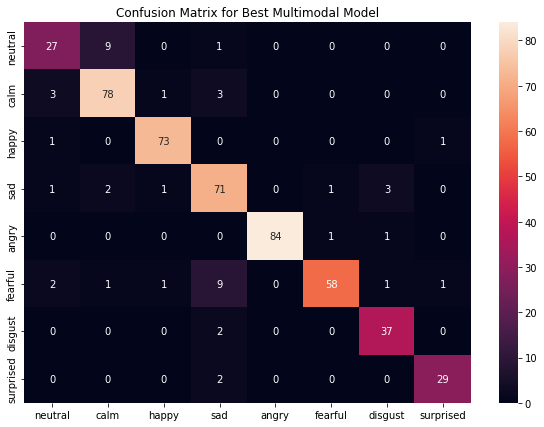

In [66]:
df_cm = pd.DataFrame(cm, index = [i for i in all_emotions],
                  columns = [i for i in all_emotions])
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix for Best Multimodal Model")
sn.heatmap(df_cm, annot=True)

In [ ]:
# dev_avdata.DATAHANDLES[:30]

In [ ]:
# dev_avdata.DATAHANDLES[0]
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
tmp = torch.cat([train_transforms(dev_avdata.video_data[x]) for x in dev_avdata.DATAHANDLES[1]['video']], dim=2)

In [ ]:
tmp.shape# dev_avdata.DATAHANDLES[2]

torch.Size([3, 64, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


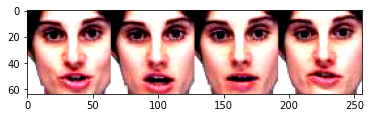

In [ ]:
plt.imshow(0.5 + tmp.permute(1, 2, 0)/2)

In [ ]:
pbar = tqdm(range(2000))
for i in pbar:
  time.sleep(0.001)
  pbar.set_description(f"TIME is : {time.time()}TIME is : {time.time()}TIME is : {time.time()}TIME is : {time.time()}TIME is : {time.time()}TIME is : {time.time()}")

TIME is : 1638414090.7201345TIME is : 1638414090.720142TIME is : 1638414090.720144TIME is : 1638414090.7201455TIME is : 1638414090.7201471TIME is : 1638414090.7201488: 100%|██████████| 2000/2000 [00:05<00:00, 354.24it/s]
